# 자치구와 고장의 연관성 분석

<br>
<br>

In [17]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [24]:
df_rent = pd.read_csv("training_data7~12.csv")
df_office = pd.read_csv("공공자전거 대여소 정보(22.12월 기준).csv")

In [28]:
df_region = df_office[['대여소 번호', '자치구']]
df_rentlog = pd.merge(df_rent, df_region, how='left', left_on='대여 대여소번호', right_on='대여소 번호')
df_rentlog.drop('대여소 번호', axis=1, inplace=True)
df_rentlog.dropna(subset=['자치구'], inplace=True)
df_rentlog.shape

(26267, 17)

In [57]:
broken_count = df_rentlog.groupby('자치구')['고장'].sum()
total_count = df_rentlog['자치구'].value_counts()
broken_ratio = broken_count / total_count
print('고장비율')
broken_ratio

고장비율


강남구     0.397510
강동구     0.577002
강북구     0.512968
강서구     0.497791
관악구     0.538235
광진구     0.520599
구로구     0.492704
금천구     0.543750
노원구     0.462006
도봉구     0.523109
동대문구    0.513333
동작구     0.511029
마포구     0.569124
서대문구    0.571918
서초구     0.473034
성동구     0.563910
성북구     0.533435
송파구     0.553371
양천구     0.552467
영등포구    0.507737
용산구     0.362573
은평구     0.617057
종로구     0.320996
중구      0.340488
중랑구     0.606838
dtype: float64

In [34]:
!pip install geopandas matplotlib mapclassify

     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     -- ------------------------------------- 0.1/1.1 MB 2.0 MB/s eta 0:00:01
     --------- ------------------------------ 0.3/1.1 MB 3.2 MB/s eta 0:00:01
     ---------------- ----------------------- 0.5/1.1 MB 3.5 MB/s eta 0:00:01
     ---------------------- ----------------- 0.6/1.1 MB 3.6 MB/s eta 0:00:01
     ----------------------------- ---------- 0.8/1.1 MB 3.7 MB/s eta 0:00:01
     ---------------------------------- ----- 1.0/1.1 MB 3.6 MB/s eta 0:00:01
     ---------------------------------------- 1.1/1.1 MB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/22.7 MB ? eta -:--:--
     --------------------------------------- 0.0/22.7 MB 991.0 kB/s eta 0:00:23
     ---------------------------------------- 0.3/22.7 MB 3.2 MB/s eta 0:00:08
      --------------------------------------- 0.5/22.7 MB 3.4 MB/s eta 0:00:07
     - -------------------------------------- 0.7/22.7 MB 3.8 MB/s eta 0:

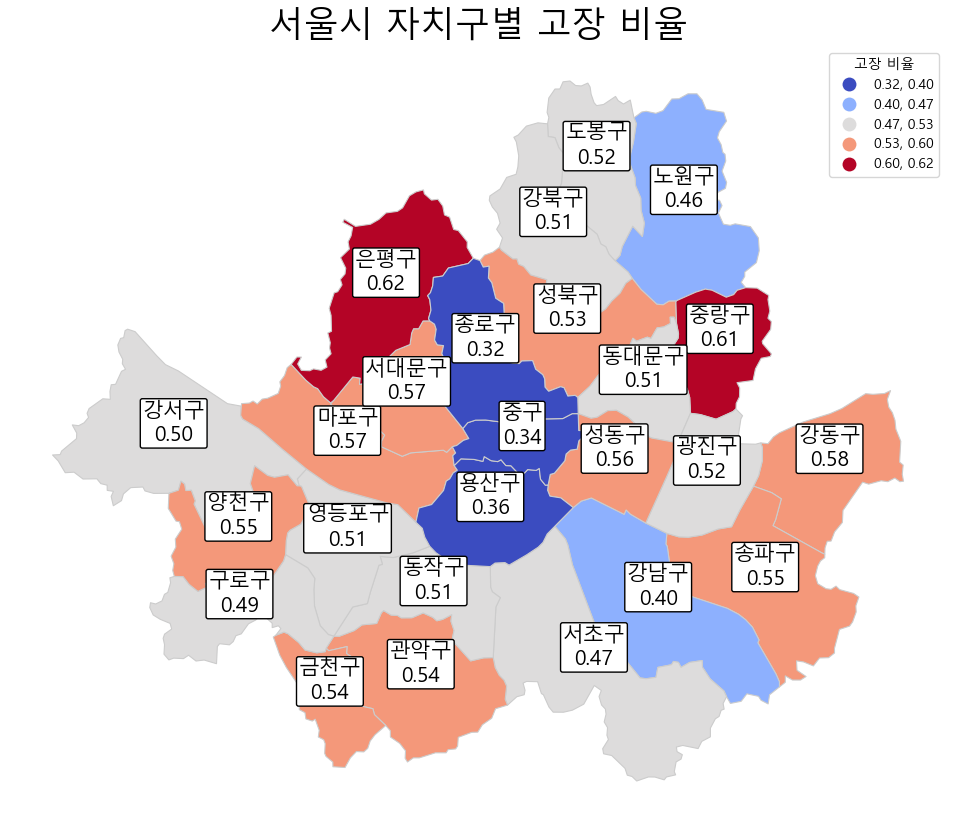

In [68]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify

# fault_ratio 데이터프레임의 열 이름 고치기
fault_ratio = pd.DataFrame(broken_ratio).reset_index()
fault_ratio.columns = ['자치구', '고장비율']

# 서울시 자치구 경계 데이터
url = "https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json"
seoul_districts = gpd.read_file(url)

# fault_ratio 데이터프레임와 서울 자치구 데이터 병합
merged_data = seoul_districts.set_index('name').join(fault_ratio.set_index('자치구'))

# 속성별 지도 그리기
fig, ax = plt.subplots(1, figsize=(15, 10))
bins = [0.395, 0.47, 0.53, 0.6]
merged_data.plot(column='고장비율', cmap='coolwarm', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax, scheme='userdefined', classification_kwds={'bins': bins}, missing_kwds={'color': 'lightgrey', "label": "Missing values"}, legend_kwds={'title': '고장 비율', 'fmt': '{:.2f}'})

# 자치구 이름과 고장 비율 표시
for idx, row in merged_data.iterrows():
    plt.annotate(text=f"{idx}\n{row['고장비율']:.2f}", xy=row['geometry'].centroid.coords[0], horizontalalignment='center', fontsize=15, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))

ax.axis('off')
ax.set_title('서울시 자치구별 고장 비율', fontsize=25)
plt.show()


## 분석 결과

서울시의 25개의 자치구 각각의 고장비율을 분석했습니다.

예상보다 자치구에 따라 편차가 컸습니다. 특정 구는 고장 비율과 정상 비율이 차이가 매우 큰 것을 확인할 수 있었습니다.

**고장 비율이 정상 비율보다 50% 이상 높은 자치구는 '은평구', '중랑구'입니다.**

**정상 비율이 고장 비율보다 50% 이상 높은 자치구는 '종로구', '중구', '용산구'입니다. 특히 '종로구'는 정상 비율이 2배 이상 높습니다.**

<br>

## 해석

어떤 이유로 특정 자치구의 고장 비율이 높거나 낮은지는 추측이 힘들어보입니다.

한가지 지도에서 눈에 띄는 공통점은 **"서울 중심부는 고장이 적다"** 인 것 같습니다.